In [1]:
from  google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
import os, gc, sys
import random
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import fbeta_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
SEED = 2021
BASE_PATH = '/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ/input/'
TEXT_COL = "clean_abstract"
TARGET = "judgement"
NUM_CLASS = 2

In [115]:
def seed_everything(seed):
    """for reproducibility.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def metric_fbeta(preds, data):
    """F1 evaluation function for lgbm model.
    """
    
    y_true = data.get_label()
    #preds = preds.reshape(NUM_CLASS, len(preds) // NUM_CLASS)
    y_pred = pd.Series(preds)
    score = fbeta_score(y_true, preds.round(), beta=7)
    return "metric_fbeta", score, True

def train_and_predict(X, y, X_test, n_folds):
    """An evaluation function to train and predict.
    """
    y_pred = np.zeros((X_test.shape[0], y.nunique()), dtype='float32')
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns
    scores = []
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    models =[]

    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid)
        params = {
            'objective': 'binary',
            'metric': 'None',
            'learning_rate': 0.01,
            'max_depth': -1,
            'num_leaves': 31,
            'max_bin': 31,
            'min_data_in_leaf': 3,
            'verbose': -1,
            'seed': SEED,
            'drop_seed': SEED,
            'data_random_seed':SEED
        }

        model = lgb.train(params, train_data, valid_sets=valid_data,
                         num_boost_round=1000, early_stopping_rounds=100,
                         verbose_eval=10, feval=metric_fbeta)
        y_val_pred = model.predict(X_valid)
        score = fbeta_score(y_valid, y_val_pred.round(), beta=7)
        scores.append(score)
        print("Fold {}: Score: {:.4f}".format(fold, score))
        models.append(model)
        feature_importances['fold_{}'.format(fold)] = model.feature_importance(importance_type='gain')
        gc.collect()
    preds = []
    for m in models:
      pred = m.predict(X_test,num_iteration=m.best_iteration)
      preds.append(pred)
    preds_array = np.array(preds)
    preds_mean = np.mean(preds_array,axis=0)
    y_pred = (preds_mean>0.5).astype(int)
    print("CV: {:.4f}".format(np.mean(scores)))
    feature_importances['importance'] = feature_importances.iloc[:,1:1+n_folds].mean(axis=1)
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    return scores, feature_importances, y_pred

# Init.
seed_everything(SEED)

In [116]:
train = pd.read_csv(BASE_PATH + "train_clean_df.csv")
test = pd.read_csv(BASE_PATH + "test_clean_df.csv")

In [117]:
train.shape, test.shape

((27145, 7), (40834, 7))

In [118]:
train['judgement'].value_counts()

0.0    26513
1.0      632
Name: judgement, dtype: int64

In [119]:
train['clean_abstract'].replace(np.nan,'',regex=True)
test['clean_abstract'].replace(np.nan,'',regex=True)

0         objective   paper   analyse changes  food com...
1                                                         
2        15o water pet  performed  patients  structural...
3         present  method  significantly improves magne...
4         objective   study   compare  epidemiological ...
                               ...                        
40829      current outbreak  novel coronavirus covid he...
40830    background   novel sars cov pandemic occurred ...
40831    positron emission tomography pet   imaging mod...
40832                                                     
40833    purpose  follow   patients  malignant brain tu...
Name: clean_abstract, Length: 40834, dtype: object

In [120]:
data_abstract = pd.concat([train['clean_abstract'], test['clean_abstract']], axis=0)
data_abstract.replace(np.nan,'',inplace=True)
data_title = pd.concat([train['clean_title'],test['clean_title']],axis=0)
data_title.replace(np.nan,'',inplace=True)

In [121]:
vc = CountVectorizer()
df_abstract_vc = vc.fit_transform(data_abstract)
df_title_vc = vc.fit_transform(data_title)

In [124]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=20,random_state=SEED)
pca_abstract_voc_df = pd.DataFrame(pca.fit_transform(df_abstract_vc))
pca_abstract_voc_df.columns = ['pca_voc_abstract_' + str(col) for col in pca_abstract_voc_df.columns]

pca_title_voc_df = pd.DataFrame(pca.fit_transform(df_title_vc))
pca_title_voc_df.columns = ['pca_voc_title_' + str(col) for col in pca_title_voc_df.columns]

In [125]:
pca_abstract_voc_df

,pca_voc_abstract_0,pca_voc_abstract_1,pca_voc_abstract_2,pca_voc_abstract_3,pca_voc_abstract_4,pca_voc_abstract_5,pca_voc_abstract_6,pca_voc_abstract_7,pca_voc_abstract_8,pca_voc_abstract_9,pca_voc_abstract_10,pca_voc_abstract_11,pca_voc_abstract_12,pca_voc_abstract_13,pca_voc_abstract_14,pca_voc_abstract_15,pca_voc_abstract_16,pca_voc_abstract_17,pca_voc_abstract_18,pca_voc_abstract_19
0,2.932232e+00,2.956640e+00,-1.133828e+00,-6.255921e-01,3.556339e+00,-1.717037e+00,-1.514336e-01,-4.517281e-01,-1.743292e+00,-3.493960e+00,-8.815680e-01,2.474452e+00,-1.441871e+00,-1.895862e+00,-8.777003e-01,-2.507648e+00,-1.853802e-02,6.216968e-01,8.412170e-01,2.898970e+00
1,4.948666e+00,7.367477e+00,-3.546132e+00,-1.637294e+00,-3.345601e+00,-3.066663e+00,-1.061592e+00,8.279990e+00,4.420991e+00,8.145156e-01,2.665946e+00,1.880506e+00,1.611757e+00,1.331284e+00,9.030037e-01,8.589137e-01,2.205784e+00,-6.283166e-01,-9.217240e-01,1.503132e-01
2,4.270038e+00,6.817023e-01,2.392828e+00,7.629395e-01,1.279681e+00,7.217293e-01,2.924312e-02,4.612735e-02,1.063288e-01,-1.792294e-01,2.925583e-02,-4.439657e-02,-9.551452e-01,-1.058349e+00,-1.539901e+00,-9.360876e-01,-4.246272e-01,-6.609866e-02,-3.555703e-01,1.055841e-01
3,4.977844e+00,1.247923e+00,9.447200e-01,1.278312e+00,2.087709e+00,2.217299e+00,-5.107611e-02,6.738043e-01,-1.181165e+00,2.073786e+00,7.256113e-01,-2.065069e+00,1.476182e-01,-3.415407e-01,-2.075317e+00,1.049775e+00,2.788247e-01,2.738647e+00,-2.138401e-01,-1.314338e-01
4,-1.434589e-18,-1.308518e-16,1.572287e-14,4.239116e-14,2.962606e-13,-2.295963e-13,2.876656e-13,3.943980e-13,3.128964e-13,1.993165e-13,-1.395311e-14,-1.581071e-14,1.329379e-15,-1.035456e-14,-2.852287e-14,1.331315e-14,-1.876773e-14,-1.954450e-14,1.372978e-14,8.823136e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67974,2.968241e+00,-1.764606e+00,-2.399151e+00,-2.014646e+00,8.218194e-01,-6.000712e-01,1.996728e-01,-1.634641e-01,1.423749e-02,-1.054767e+00,-1.633138e-01,-5.072282e-01,1.211230e+00,3.005445e-01,-4.206614e-01,-4.724741e-01,-5.450155e-01,6.870057e-02,-5.541376e-03,-5.321256e-02
67975,8.769431e+00,-2.737076e+00,-1.065458e+00,-8.552601e-01,-4.479916e-01,-2.994708e-01,-5.166857e-03,-1.223578e-01,-8.007859e-01,-3.703680e-01,-7.410481e-01,1.880497e-01,1.321891e+00,-4.342931e-01,-1.455600e-01,2.684477e-01,1.394884e+00,1.039240e+00,-1.524450e+00,-4.388297e-01
67976,1.058011e+00,9.271161e-01,2.479945e-01,6.079413e-01,2.931611e+00,1.051883e+00,1.049423e-01,-1.842974e-01,2.063741e+00,3.499857e-03,-1.172895e+00,-1.869644e-01,7.992714e-01,3.209500e-01,3.150740e-01,-4.467978e-01,8.502332e-03,-1.285991e+00,-4.509039e-01,-3.951642e-01
67977,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00


In [126]:
pca_title_voc_df

,pca_voc_title_0,pca_voc_title_1,pca_voc_title_2,pca_voc_title_3,pca_voc_title_4,pca_voc_title_5,pca_voc_title_6,pca_voc_title_7,pca_voc_title_8,pca_voc_title_9,pca_voc_title_10,pca_voc_title_11,pca_voc_title_12,pca_voc_title_13,pca_voc_title_14,pca_voc_title_15,pca_voc_title_16,pca_voc_title_17,pca_voc_title_18,pca_voc_title_19
0,0.094159,0.138407,0.005449,0.021653,0.133146,0.464654,0.110686,-0.080638,0.014329,0.063099,-0.143060,-0.424657,0.738088,0.200791,-0.306884,-0.205682,-0.067071,-0.040125,0.120805,0.067621
1,0.494652,1.182918,-0.074289,0.181737,0.069998,0.854445,-0.653086,0.218717,-0.545517,-0.724886,0.277981,-0.146277,-0.009198,0.468238,1.146564,0.028212,0.242816,-0.218941,0.271461,-0.422634
2,0.027632,0.027464,0.025457,0.008197,0.054704,0.067848,0.080553,-0.051556,0.007658,-0.000380,0.009560,-0.057611,0.044324,0.018168,-0.013648,0.030531,-0.039585,0.058515,0.034394,-0.001507
3,0.349010,0.764617,-0.046765,-0.163482,-0.311524,-0.132099,0.312906,-0.033709,-0.028725,0.023613,-0.017549,-0.010718,-0.224545,-0.138488,-0.242118,0.043062,-0.033463,0.149171,0.247547,0.215633
4,1.167481,-0.412352,1.200121,0.336227,-0.388443,0.039569,0.165794,-0.201595,0.646775,-0.578476,0.852144,-0.392600,-0.220217,0.060172,-0.459051,0.115171,-0.067051,-0.005539,0.014670,-0.378242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67974,1.095320,-0.344588,-0.158524,0.100684,-0.054750,0.498412,-0.002595,0.807989,-0.424899,-0.508308,-0.081010,0.166158,0.133219,-0.245432,-0.015508,0.020068,0.009644,-0.014856,0.059871,-0.027294
67975,0.838920,0.844196,0.179466,-0.829287,0.254688,-0.725728,0.523157,0.282015,0.184830,0.419365,-0.263715,0.050721,0.330037,-0.076504,0.150147,0.612214,0.063905,-0.462072,-0.145031,0.027828
67976,0.101108,0.139258,0.047652,-0.144797,0.262784,1.009389,1.034520,-0.801632,-0.202251,0.224925,0.242896,0.846733,-0.152912,-0.309962,0.179627,-0.059441,-0.328281,-0.249932,-0.199171,-0.171708
67977,0.038215,0.049987,0.012859,-0.035343,0.069713,0.301666,0.257769,-0.170653,-0.011936,0.076732,-0.245454,-0.204145,-0.369709,-0.338370,0.124696,-0.167980,-0.417803,-0.216447,-0.167101,-0.099107


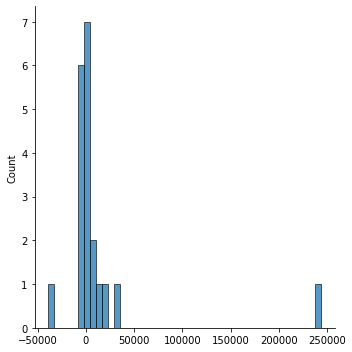

In [16]:
sns.displot(pca_abstract_df.sum())

In [127]:
tfidf = TfidfVectorizer()
abstract_tfidf_df = tfidf.fit_transform(data_abstract)
title_tfidf_df = tfidf.fit_transform(data_title)

pca = TruncatedSVD(n_components=20,random_state=SEED)

pca_abstract_tfidf_df = pd.DataFrame(pca.fit_transform(abstract_tfidf_df))
pca_abstract_tfidf_df.columns = ['pca_tfidf_abstract_' + str(col) for col in pca_abstract_tfidf_df.columns]
pca_title_tfidf_df = pd.DataFrame(pca.fit_transform(title_tfidf_df))
pca_title_tfidf_df.columns = ['pca_tfidf_title_' + str(col) for col in pca_title_tfidf_df.columns]

In [128]:
pca_abstract_tfidf_df

,pca_tfidf_abstract_0,pca_tfidf_abstract_1,pca_tfidf_abstract_2,pca_tfidf_abstract_3,pca_tfidf_abstract_4,pca_tfidf_abstract_5,pca_tfidf_abstract_6,pca_tfidf_abstract_7,pca_tfidf_abstract_8,pca_tfidf_abstract_9,pca_tfidf_abstract_10,pca_tfidf_abstract_11,pca_tfidf_abstract_12,pca_tfidf_abstract_13,pca_tfidf_abstract_14,pca_tfidf_abstract_15,pca_tfidf_abstract_16,pca_tfidf_abstract_17,pca_tfidf_abstract_18,pca_tfidf_abstract_19
0,1.641862e-01,1.399359e-01,-8.519417e-02,-4.705434e-02,1.127116e-01,-1.195817e-01,2.801323e-02,-7.204062e-02,-1.387969e-01,-1.926357e-02,1.122929e-01,4.539448e-03,3.121121e-02,3.453154e-02,-2.354757e-02,3.955842e-04,-4.561646e-02,-4.978183e-02,-6.495759e-02,7.761520e-02
1,1.892091e-01,2.384308e-01,9.146612e-02,-9.647900e-02,9.872797e-02,2.924154e-01,2.053325e-01,7.005325e-02,9.253100e-02,2.072637e-02,9.704216e-03,4.393347e-03,-2.225548e-03,4.060461e-02,-2.560716e-02,-2.405251e-02,-4.447538e-03,1.724779e-02,-9.213823e-03,-2.346466e-02
2,1.838881e-01,4.109414e-02,-1.314111e-01,7.938662e-02,-3.044360e-02,4.223176e-03,3.035153e-03,-6.432736e-02,-3.873436e-02,-4.039905e-02,1.482179e-02,-9.421162e-02,-2.146319e-02,-1.741620e-02,-1.639097e-02,3.118701e-02,-5.911862e-02,-1.487617e-02,-1.159281e-02,6.760612e-02
3,1.637076e-01,2.961308e-02,-5.380906e-02,9.027176e-02,-6.621516e-02,5.426473e-03,1.009424e-02,-1.214337e-01,7.004989e-03,3.656285e-02,-7.333304e-02,-2.800518e-02,-2.821738e-02,1.745640e-02,1.370301e-01,-5.342568e-02,-4.041412e-02,9.078726e-02,-6.642889e-03,-5.832539e-02
4,2.149565e-19,2.620036e-17,2.334332e-16,-4.696384e-16,-2.853382e-15,-3.086504e-15,-1.060241e-15,-8.991779e-16,-4.011285e-16,-9.671651e-16,-1.258575e-15,-2.335187e-16,-1.212323e-16,-2.800396e-17,-1.824436e-16,3.154207e-16,3.049183e-16,2.069198e-16,3.722195e-16,-2.655394e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67974,1.458081e-01,-6.626093e-02,6.367953e-03,-1.096284e-01,-2.952715e-02,-8.118727e-02,8.310177e-02,2.117926e-02,-1.031745e-02,4.431888e-02,-2.882593e-02,-2.080475e-02,4.809277e-02,-9.260338e-03,1.158587e-02,-4.974630e-02,-4.740369e-03,6.281827e-03,7.383826e-03,1.571350e-02
67975,2.569951e-01,-8.484824e-02,-1.089548e-02,-5.537835e-02,-3.617180e-03,3.948633e-02,-5.867282e-02,3.616231e-02,-6.309064e-02,-1.876244e-02,-1.385070e-02,-7.009258e-03,-4.553287e-02,3.894229e-02,2.152760e-02,-4.591373e-02,1.213564e-02,1.172170e-02,-2.272988e-02,-1.900157e-02
67976,7.885996e-02,5.933901e-02,-1.267491e-01,1.460393e-01,-8.125816e-02,-5.368267e-02,8.819631e-02,1.171817e-01,-1.658641e-02,-4.646477e-02,1.048049e-02,-3.686812e-02,9.334414e-03,2.217336e-02,-2.553031e-02,1.978220e-02,2.138406e-02,1.245960e-02,-5.478266e-04,9.816393e-03
67977,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00


In [129]:
pca_title_tfidf_df

,pca_tfidf_title_0,pca_tfidf_title_1,pca_tfidf_title_2,pca_tfidf_title_3,pca_tfidf_title_4,pca_tfidf_title_5,pca_tfidf_title_6,pca_tfidf_title_7,pca_tfidf_title_8,pca_tfidf_title_9,pca_tfidf_title_10,pca_tfidf_title_11,pca_tfidf_title_12,pca_tfidf_title_13,pca_tfidf_title_14,pca_tfidf_title_15,pca_tfidf_title_16,pca_tfidf_title_17,pca_tfidf_title_18,pca_tfidf_title_19
0,0.069547,0.053428,-0.006188,0.054137,0.001945,0.064953,-0.027293,0.009755,-0.034999,-0.024597,-0.017436,-0.069066,-0.007661,0.074258,-0.106945,0.135757,0.090855,0.058779,0.029792,0.063451
1,0.134927,0.138259,-0.004911,-0.005442,0.028661,0.013504,-0.052098,-0.056579,-0.040249,-0.097143,-0.038601,-0.071387,-0.048821,0.082431,0.072035,-0.074670,0.017809,0.043720,-0.022125,-0.067285
2,0.021189,0.010130,0.007491,0.031790,-0.024392,0.007938,-0.000629,0.006054,-0.011710,-0.013171,-0.001919,-0.004650,0.010474,0.016897,-0.004979,0.032841,0.017836,0.040551,0.014490,-0.004623
3,0.108120,0.076367,-0.008612,0.034984,-0.003139,-0.117340,-0.053456,0.019361,-0.046593,-0.023819,-0.000355,0.032173,0.044723,-0.063449,0.092027,-0.121960,0.026435,0.167541,-0.027624,0.024999
4,0.191603,-0.167938,0.203733,0.000064,0.004184,-0.026806,-0.020888,0.231931,0.007501,-0.198959,-0.015446,0.024230,-0.085605,-0.080780,-0.024396,0.056598,-0.065713,-0.007698,-0.062315,0.006348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67974,0.115934,-0.068074,-0.058406,-0.024667,0.008989,0.058461,-0.055637,-0.053946,-0.008863,0.006646,-0.060312,-0.123071,-0.088774,0.021830,-0.100722,-0.098316,-0.031524,0.036513,0.001973,0.032240
67975,0.180363,-0.000629,-0.013449,-0.012683,0.022244,-0.124493,0.095120,-0.008012,0.046991,0.090971,0.048797,0.002464,0.053382,0.060552,-0.033207,0.029267,-0.043264,0.027021,-0.035079,-0.026410
67976,0.085758,0.062776,-0.001622,0.410946,-0.216797,0.043520,-0.144870,-0.036057,0.229672,0.041369,0.023470,-0.053041,0.071248,-0.062326,-0.048372,0.016491,-0.036218,-0.062154,-0.015542,-0.024420
67977,0.037569,0.020535,-0.000336,0.100438,-0.043594,0.017787,-0.031269,0.012582,-0.102041,0.067750,0.007156,-0.102281,0.107628,-0.105137,-0.020732,0.006596,-0.058564,-0.067844,-0.016452,-0.032638


In [130]:
df = pd.concat([pd.concat([train,test]).reset_index(drop=True), pca_abstract_voc_df, pca_abstract_tfidf_df,pca_title_voc_df,pca_title_tfidf_df], axis=1)
train = df.iloc[:train.shape[0], :]
test = df.iloc[train.shape[0]:, :]

In [131]:
train

,Unnamed: 0,id,title,abstract,judgement,clean_title,clean_abstract,pca_voc_abstract_0,pca_voc_abstract_1,pca_voc_abstract_2,pca_voc_abstract_3,pca_voc_abstract_4,pca_voc_abstract_5,pca_voc_abstract_6,pca_voc_abstract_7,pca_voc_abstract_8,pca_voc_abstract_9,pca_voc_abstract_10,pca_voc_abstract_11,pca_voc_abstract_12,pca_voc_abstract_13,pca_voc_abstract_14,pca_voc_abstract_15,pca_voc_abstract_16,pca_voc_abstract_17,pca_voc_abstract_18,pca_voc_abstract_19,pca_tfidf_abstract_0,pca_tfidf_abstract_1,pca_tfidf_abstract_2,pca_tfidf_abstract_3,pca_tfidf_abstract_4,pca_tfidf_abstract_5,pca_tfidf_abstract_6,pca_tfidf_abstract_7,pca_tfidf_abstract_8,pca_tfidf_abstract_9,pca_tfidf_abstract_10,pca_tfidf_abstract_11,pca_tfidf_abstract_12,...,pca_voc_title_0,pca_voc_title_1,pca_voc_title_2,pca_voc_title_3,pca_voc_title_4,pca_voc_title_5,pca_voc_title_6,pca_voc_title_7,pca_voc_title_8,pca_voc_title_9,pca_voc_title_10,pca_voc_title_11,pca_voc_title_12,pca_voc_title_13,pca_voc_title_14,pca_voc_title_15,pca_voc_title_16,pca_voc_title_17,pca_voc_title_18,pca_voc_title_19,pca_tfidf_title_0,pca_tfidf_title_1,pca_tfidf_title_2,pca_tfidf_title_3,pca_tfidf_title_4,pca_tfidf_title_5,pca_tfidf_title_6,pca_tfidf_title_7,pca_tfidf_title_8,pca_tfidf_title_9,pca_tfidf_title_10,pca_tfidf_title_11,pca_tfidf_title_12,pca_tfidf_title_13,pca_tfidf_title_14,pca_tfidf_title_15,pca_tfidf_title_16,pca_tfidf_title_17,pca_tfidf_title_18,pca_tfidf_title_19
0,0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0.0,one year age changes mri brain volumes older...,longitudinal studies indicate declines cogni...,2.932232e+00,2.956640e+00,-1.133828e+00,-6.255921e-01,3.556339e+00,-1.717037e+00,-1.514336e-01,-4.517281e-01,-1.743292e+00,-3.493960e+00,-8.815680e-01,2.474452e+00,-1.441871e+00,-1.895862e+00,-8.777003e-01,-2.507648e+00,-1.853802e-02,6.216968e-01,8.412170e-01,2.898970e+00,1.641862e-01,1.399359e-01,-8.519417e-02,-4.705434e-02,1.127116e-01,-1.195817e-01,2.801323e-02,-7.204062e-02,-1.387969e-01,-1.926357e-02,1.122929e-01,4.539448e-03,3.121121e-02,...,0.094159,0.138407,0.005449,0.021653,0.133146,0.464654,0.110686,-0.080638,0.014329,0.063099,-0.143060,-0.424657,0.738088,0.200791,-0.306884,-0.205682,-0.067071,-0.040125,0.120805,0.067621,0.069547,0.053428,-0.006188,0.054137,0.001945,0.064953,-0.027293,0.009755,-0.034999,-0.024597,-0.017436,-0.069066,-0.007661,0.074258,-0.106945,0.135757,0.090855,0.058779,0.029792,0.063451
1,1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0.0,supportive csf biomarker evidence enhance na...,present study undertaken validate measurem...,4.948666e+00,7.367477e+00,-3.546132e+00,-1.637294e+00,-3.345601e+00,-3.066663e+00,-1.061592e+00,8.279990e+00,4.420991e+00,8.145156e-01,2.665946e+00,1.880506e+00,1.611757e+00,1.331284e+00,9.030037e-01,8.589137e-01,2.205784e+00,-6.283166e-01,-9.217240e-01,1.503132e-01,1.892091e-01,2.384308e-01,9.146612e-02,-9.647900e-02,9.872797e-02,2.924154e-01,2.053325e-01,7.005325e-02,9.253100e-02,2.072637e-02,9.704216e-03,4.393347e-03,-2.225548e-03,...,0.494652,1.182918,-0.074289,0.181737,0.069998,0.854445,-0.653086,0.218717,-0.545517,-0.724886,0.277981,-0.146277,-0.009198,0.468238,1.146564,0.028212,0.242816,-0.218941,0.271461,-0.422634,0.134927,0.138259,-0.004911,-0.005442,0.028661,0.013504,-0.052098,-0.056579,-0.040249,-0.097143,-0.038601,-0.071387,-0.048821,0.082431,0.072035,-0.074670,0.017809,0.043720,-0.022125,-0.067285
2,2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0.0,occurrence basal ganglia germ cell tumors wit...,objective report case series basal ganglia...,4.270038e+00,6.817023e-01,2.392828e+00,7.629395e-01,1.279681e+00,7.217293e-01,2.924312e-02,4.612735e-02,1.063288e-01,-1.792294e-01,2.925583e-02,-4.439657e-02,-9.551452e-01,-1.058349e+00,-1.539901e+00,-9.360876e-01,-4.246272e-01,-6.609866e-02,-3.555703e-01,1.055841e-01,1.838881e-01,4.109414e-02,-1.3

In [132]:
col = [c for c in train.columns if c not in ['Unnamed: 0','id','title','abstract','clean_title','clean_abstract','judgement']]
X_train = train[col]
y = train[TARGET]
X_test = test[col]

In [133]:
X_train

,pca_voc_abstract_0,pca_voc_abstract_1,pca_voc_abstract_2,pca_voc_abstract_3,pca_voc_abstract_4,pca_voc_abstract_5,pca_voc_abstract_6,pca_voc_abstract_7,pca_voc_abstract_8,pca_voc_abstract_9,pca_voc_abstract_10,pca_voc_abstract_11,pca_voc_abstract_12,pca_voc_abstract_13,pca_voc_abstract_14,pca_voc_abstract_15,pca_voc_abstract_16,pca_voc_abstract_17,pca_voc_abstract_18,pca_voc_abstract_19,pca_tfidf_abstract_0,pca_tfidf_abstract_1,pca_tfidf_abstract_2,pca_tfidf_abstract_3,pca_tfidf_abstract_4,pca_tfidf_abstract_5,pca_tfidf_abstract_6,pca_tfidf_abstract_7,pca_tfidf_abstract_8,pca_tfidf_abstract_9,pca_tfidf_abstract_10,pca_tfidf_abstract_11,pca_tfidf_abstract_12,pca_tfidf_abstract_13,pca_tfidf_abstract_14,pca_tfidf_abstract_15,pca_tfidf_abstract_16,pca_tfidf_abstract_17,pca_tfidf_abstract_18,pca_tfidf_abstract_19,pca_voc_title_0,pca_voc_title_1,pca_voc_title_2,pca_voc_title_3,pca_voc_title_4,pca_voc_title_5,pca_voc_title_6,pca_voc_title_7,pca_voc_title_8,pca_voc_title_9,pca_voc_title_10,pca_voc_title_11,pca_voc_title_12,pca_voc_title_13,pca_voc_title_14,pca_voc_title_15,pca_voc_title_16,pca_voc_title_17,pca_voc_title_18,pca_voc_title_19,pca_tfidf_title_0,pca_tfidf_title_1,pca_tfidf_title_2,pca_tfidf_title_3,pca_tfidf_title_4,pca_tfidf_title_5,pca_tfidf_title_6,pca_tfidf_title_7,pca_tfidf_title_8,pca_tfidf_title_9,pca_tfidf_title_10,pca_tfidf_title_11,pca_tfidf_title_12,pca_tfidf_title_13,pca_tfidf_title_14,pca_tfidf_title_15,pca_tfidf_title_16,pca_tfidf_title_17,pca_tfidf_title_18,pca_tfidf_title_19
0,2.932232e+00,2.956640e+00,-1.133828e+00,-6.255921e-01,3.556339e+00,-1.717037e+00,-1.514336e-01,-4.517281e-01,-1.743292e+00,-3.493960e+00,-8.815680e-01,2.474452e+00,-1.441871e+00,-1.895862e+00,-8.777003e-01,-2.507648e+00,-1.853802e-02,6.216968e-01,8.412170e-01,2.898970e+00,1.641862e-01,1.399359e-01,-8.519417e-02,-4.705434e-02,1.127116e-01,-1.195817e-01,2.801323e-02,-7.204062e-02,-1.387969e-01,-1.926357e-02,1.122929e-01,4.539448e-03,3.121121e-02,3.453154e-02,-2.354757e-02,3.955842e-04,-4.561646e-02,-4.978183e-02,-6.495759e-02,7.761520e-02,0.094159,0.138407,0.005449,0.021653,0.133146,0.464654,0.110686,-0.080638,0.014329,0.063099,-0.143060,-0.424657,0.738088,0.200791,-0.306884,-0.205682,-0.067071,-0.040125,0.120805,0.067621,0.069547,0.053428,-0.006188,0.054137,0.001945,0.064953,-0.027293,0.009755,-0.034999,-0.024597,-0.017436,-0.069066,-0.007661,0.074258,-0.106945,0.135757,0.090855,0.058779,0.029792,0.063451
1,4.948666e+00,7.367477e+00,-3.546132e+00,-1.637294e+00,-3.345601e+00,-3.066663e+00,-1.061592e+00,8.279990e+00,4.420991e+00,8.145156e-01,2.665946e+00,1.880506e+00,1.611757e+00,1.331284e+00,9.030037e-01,8.589137e-01,2.205784e+00,-6.283166e-01,-9.217240e-01,1.503132e-01,1.892091e-01,2.384308e-01,9.146612e-02,-9.647900e-02,9.872797e-02,2.924154e-01,2.053325e-01,7.005325e-02,9.253100e-02,2.072637e-02,9.704216e-03,4.393347e-03,-2.225548e-03,4.060461e-02,-2.560716e-02,-2.405251e-02,-4.447538e-03,1.724779e-02,-9.213823e-03,-2.346466e-02,0.494652,1.182918,-0.074289,0.181737,0.069998,0.854445,-0.653086,0.218717,-0.545517,-0.724886,0.277981,-0.146277,-0.009198,0.468238,1.146564,0.028212,0.242816,-0.218941,0.271461,-0.422634,0.134927,0.138259,-0.004911,-0.005442,0.028661,0.013504,-0.052098,-0.056579,-0.040249,-0.097143,-0.038601,-0.071387,-0.048821,0.082431,0.072035,-0.074670,0.017809,0.043720,-0.022125,-0.067285
2,4.270038e+00,6.817023e-01,2.392828e+00,7.629395e-01,1.279681e+00,7.217293e-01,2.924312e-02,4.612735e-02,1.063288e-01,-1.792294e-01,2.925583e-02,-4.439657e-02,-9.551452e-01,-1.058349e+00,-1.539901e+00,-9.360876e-01,-4.246272e-01,-6.609866e-02,-3.555703e-01,1.055841e-01,1.838881e-01,4.109414e-02,-1.314111e-01,7.938662e-02,-3.044360e-02,4.223176e-03,3.035153e-03,-6.432736e-02,-3.873436e-02,-4.039905e-02,1.482179e-02,-9.421162e-02,-2.146319e-02,-1.741620e-02,-1.639097e-02,3.118701e-02,-5.911862e-02,-1.487617e-02,-1.159281e-02,6.760612e-02,0.027632,0.027464,0.025457,0.008197,0.054704,0.067848,0.080553,-0.051556,0.007658,-0.000380,0.009560

In [134]:
score, feim, ypred = train_and_predict(X_train, y, X_test, n_folds=4)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's metric_fbeta: 0
[20]	valid_0's metric_fbeta: 0
[30]	valid_0's metric_fbeta: 0
[40]	valid_0's metric_fbeta: 0
[50]	valid_0's metric_fbeta: 0
[60]	valid_0's metric_fbeta: 0
[70]	valid_0's metric_fbeta: 0
[80]	valid_0's metric_fbeta: 0.0324675
[90]	valid_0's metric_fbeta: 0.0778513
[100]	valid_0's metric_fbeta: 0.103721
[110]	valid_0's metric_fbeta: 0.123073
[120]	valid_0's metric_fbeta: 0.135958
[130]	valid_0's metric_fbeta: 0.148867
[140]	valid_0's metric_fbeta: 0.1553
[150]	valid_0's metric_fbeta: 0.174599
[160]	valid_0's metric_fbeta: 0.181019
[170]	valid_0's metric_fbeta: 0.187435
[180]	valid_0's metric_fbeta: 0.193849
[190]	valid_0's metric_fbeta: 0.213123
[200]	valid_0's metric_fbeta: 0.225952
[210]	valid_0's metric_fbeta: 0.258065
[220]	valid_0's metric_fbeta: 0.258065
[230]	valid_0's metric_fbeta: 0.258065
[240]	valid_0's metric_fbeta: 0.264482
[250]	valid_0's metric_fbeta: 0.270898
[260]	valid_0's metr

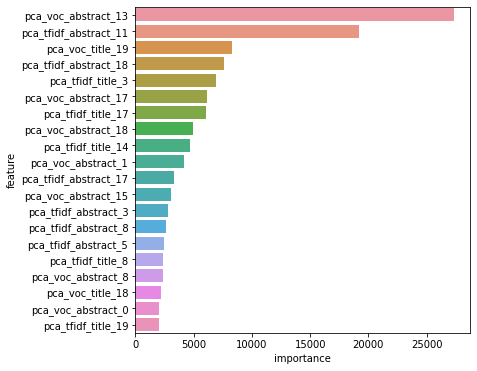

In [135]:
 plt.figure(figsize=(6, 6))
sns.barplot(data=feim.head(20), x='importance', y='feature')

In [136]:
feim

,feature,fold_0,fold_1,fold_2,fold_3,importance
13,pca_voc_abstract_13,26801.353081,26586.985078,30035.557310,26015.446278,27359.835437
31,pca_tfidf_abstract_11,18881.734370,20498.921332,16345.642280,21126.074131,19213.093028
59,pca_voc_title_19,10114.947787,8318.341809,6969.766657,7945.270591,8337.081711
38,pca_tfidf_abstract_18,8538.720393,7722.667910,7167.685068,6946.084705,7593.789519
63,pca_tfidf_title_3,7107.802088,6384.271235,8368.707962,5785.784324,6911.641402
...,...,...,...,...,...,...
10,pca_voc_abstract_10,746.609012,697.132051,635.310540,697.694016,694.186405
16,pca_voc_abstract_16,877.643093,651.256173,801.711302,363.464481,673.518762
6,pca_voc_abstract_6,556.234839,646.593915,372.419039,792.691359,591.984788
52,pca_voc_title_12,638.413061,802.620450,574.748284,322.867889,584.662421


In [143]:
top_feim = feim.query('1500<importance')
top_feim

,feature,fold_0,fold_1,fold_2,fold_3,importance
13,pca_voc_abstract_13,26801.353081,26586.985078,30035.557310,26015.446278,27359.835437
31,pca_tfidf_abstract_11,18881.734370,20498.921332,16345.642280,21126.074131,19213.093028
59,pca_voc_title_19,10114.947787,8318.341809,6969.766657,7945.270591,8337.081711
38,pca_tfidf_abstract_18,8538.720393,7722.667910,7167.685068,6946.084705,7593.789519
63,pca_tfidf_title_3,7107.802088,6384.271235,8368.707962,5785.784324,6911.641402
17,pca_voc_abstract_17,6243.706201,6952.079255,5519.894583,5942.432208,6164.528062
77,pca_tfidf_title_17,7066.331634,6120.653893,5529.209496,5526.460377,6060.663850
18,pca_voc_abstract_18,5994.746762,4731.965497,4910.898198,4102.113886,4934.931086
74,pca_tfidf_title_14,5435.647575,5733.576027,2959.106660,4626.863341,4688.798401
1,pca_voc_abstract_1,3401.075298,4379.976705,5128.547168,3824.223951,4183.455781


In [144]:
Top_feim_list = list(top_feim['feature'])

In [145]:
print(Top_feim_list)

['pca_voc_abstract_13', 'pca_tfidf_abstract_11', 'pca_voc_title_19', 'pca_tfidf_abstract_18', 'pca_tfidf_title_3', 'pca_voc_abstract_17', 'pca_tfidf_title_17', 'pca_voc_abstract_18', 'pca_tfidf_title_14', 'pca_voc_abstract_1', 'pca_tfidf_abstract_17', 'pca_voc_abstract_15', 'pca_tfidf_abstract_3', 'pca_tfidf_abstract_8', 'pca_tfidf_abstract_5', 'pca_tfidf_title_8', 'pca_voc_abstract_8', 'pca_voc_title_18', 'pca_voc_abstract_0', 'pca_tfidf_title_19', 'pca_tfidf_title_11', 'pca_voc_title_16', 'pca_voc_title_2', 'pca_tfidf_title_13', 'pca_tfidf_abstract_15', 'pca_tfidf_abstract_9', 'pca_voc_title_17', 'pca_tfidf_abstract_19', 'pca_tfidf_title_10', 'pca_tfidf_title_15', 'pca_voc_title_0', 'pca_tfidf_title_18', 'pca_voc_abstract_12']


In [146]:
X_train = train[Top_feim_list]
y = train[TARGET]
X_test = test[Top_feim_list]

In [147]:
X_train

,pca_voc_abstract_13,pca_tfidf_abstract_11,pca_voc_title_19,pca_tfidf_abstract_18,pca_tfidf_title_3,pca_voc_abstract_17,pca_tfidf_title_17,pca_voc_abstract_18,pca_tfidf_title_14,pca_voc_abstract_1,pca_tfidf_abstract_17,pca_voc_abstract_15,pca_tfidf_abstract_3,pca_tfidf_abstract_8,pca_tfidf_abstract_5,pca_tfidf_title_8,pca_voc_abstract_8,pca_voc_title_18,pca_voc_abstract_0,pca_tfidf_title_19,pca_tfidf_title_11,pca_voc_title_16,pca_voc_title_2,pca_tfidf_title_13,pca_tfidf_abstract_15,pca_tfidf_abstract_9,pca_voc_title_17,pca_tfidf_abstract_19,pca_tfidf_title_10,pca_tfidf_title_15,pca_voc_title_0,pca_tfidf_title_18,pca_voc_abstract_12
0,-1.895862e+00,4.539448e-03,0.067621,-6.495759e-02,0.054137,6.216968e-01,0.058779,8.412170e-01,-0.106945,2.956640e+00,-4.978183e-02,-2.507648e+00,-4.705434e-02,-1.387969e-01,-1.195817e-01,-0.034999,-1.743292e+00,0.120805,2.932232e+00,0.063451,-0.069066,-0.067071,0.005449,0.074258,3.955842e-04,-1.926357e-02,-0.040125,7.761520e-02,-0.017436,0.135757,0.094159,0.029792,-1.441871e+00
1,1.331284e+00,4.393347e-03,-0.422634,-9.213823e-03,-0.005442,-6.283166e-01,0.043720,-9.217240e-01,0.072035,7.367477e+00,1.724779e-02,8.589137e-01,-9.647900e-02,9.253100e-02,2.924154e-01,-0.040249,4.420991e+00,0.271461,4.948666e+00,-0.067285,-0.071387,0.242816,-0.074289,0.082431,-2.405251e-02,2.072637e-02,-0.218941,-2.346466e-02,-0.038601,-0.074670,0.494652,-0.022125,1.611757e+00
2,-1.058349e+00,-9.421162e-02,-0.001507,-1.159281e-02,0.031790,-6.609866e-02,0.040551,-3.555703e-01,-0.004979,6.817023e-01,-1.487617e-02,-9.360876e-01,7.938662e-02,-3.873436e-02,4.223176e-03,-0.011710,1.063288e-01,0.034394,4.270038e+00,-0.004623,-0.004650,-0.039585,0.025457,0.016897,3.118701e-02,-4.039905e-02,0.058515,6.760612e-02,-0.001919,0.032841,0.027632,0.014490,-9.551452e-01
3,-3.415407e-01,-2.800518e-02,0.215633,-6.642889e-03,0.034984,2.738647e+00,0.167541,-2.138401e-01,0.092027,1.247923e+00,9.078726e-02,1.049775e+00,9.027176e-02,7.004989e-03,5.426473e-03,-0.046593,-1.181165e+00,0.247547,4.977844e+00,0.024999,0.032173,-0.033463,-0.046765,-0.063449,-5.342568e-02,3.656285e-02,0.149171,-5.832539e-02,-0.000355,-0.121960,0.349010,-0.027624,1.476182e-01
4,-1.035456e-14,-2.335187e-16,-0.378242,3.722195e-16,0.000064,-1.954450e-14,-0.007698,1.372978e-14,-0.024396,-1.308518e-16,2.069198e-16,1.331315e-14,-4.696384e-16,-4.011285e-16,-3.086504e-15,0.007501,3.128964e-13,0.014670,-1.434589e-18,0.006348,0.024230,-0.067051,1.200121,-0.080780,3.154207e-16,-9.671651e-16,-0.005539,-2.655394e-16,-0.015446,0.056598,1.167481,-0.062315,1.329379e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27140,-2.514844e+00,1.228727e-01,0.042310,1.303129e-02,-0.121132,-8.664177e-01,0.013193,-4.611109e-01,0.027600,3.374063e+00,-5.213008e-03,3.348573e+00,1.664846e-02,-7.197127e-02,-5.542507e-02,0.017251,-1.042973e+00,-0.230823,1.797892e+00,-0.038430,-0.010090,-0.395523,0.043432,-0.009288,9.518056e-02,-1.108511e-01,0.498820,7.037989e-02,-0.001452,-0.002581,0.067763,-0.011105,7.383225e-02
27141,-4.312333e-02,-1.181026e-02,-0.000598,-7.628989e-04,0.012664,4.065168e-01,0.007854,-9.903959e-02,-0.005032,9.587532e-02,-3.035668e-03,7.919612e-02,1.741612e-02,-5.711820e-03,-2.741434e-02,-0.004273,7.237494e-02,-0.000524,2.285065e-01,-0.001894,0.001526,0.006851,0.000408,0.002702,-2.858146e-02,1.056505e-03,0.004305,1.632349e-02,0.001069,0.011337,0.003096,-0.000638,-1.124993e-01
27142,3.206744e-01,8.500779e-04,-0.050793,2.277543e-02,-0.024563,7.073030e-01,0.026932,-6.489477e-01,-0.016026,1.287469e+00,-9.983401e-03,1.641640e-01,1.518427e-02,-7.401421e-02,1.741550e-01,0.006407,3.144510e-01,-0.247184,8.689344e-01,-0.062515,0.007231,-0.252932,0.043303,0.026379,-7.418231e-02,-1.099280e-02,0.386434,-3.780275e-02,0.001065,0.030126,0.056551,-0.007342,-3.516208e-01
27143,8.941127e-01,-2.689759e-02,-0.114044,4.144779e-02,0.106167,-1.139532e+00,-0.068313,-1.051674e-01,-0.031017,1.257121e+00,4.006655e-02,-6.601990e

In [148]:
score, feim, ypred = train_and_predict(X_train, y, X_test, n_folds=4)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's metric_fbeta: 0
[20]	valid_0's metric_fbeta: 0
[30]	valid_0's metric_fbeta: 0
[40]	valid_0's metric_fbeta: 0
[50]	valid_0's metric_fbeta: 0
[60]	valid_0's metric_fbeta: 0
[70]	valid_0's metric_fbeta: 0
[80]	valid_0's metric_fbeta: 0.0259808
[90]	valid_0's metric_fbeta: 0.0584112
[100]	valid_0's metric_fbeta: 0.0907794
[110]	valid_0's metric_fbeta: 0.1554
[120]	valid_0's metric_fbeta: 0.174735
[130]	valid_0's metric_fbeta: 0.187557
[140]	valid_0's metric_fbeta: 0.187532
[150]	valid_0's metric_fbeta: 0.200388
[160]	valid_0's metric_fbeta: 0.213206
[170]	valid_0's metric_fbeta: 0.226011
[180]	valid_0's metric_fbeta: 0.232438
[190]	valid_0's metric_fbeta: 0.245256
[200]	valid_0's metric_fbeta: 0.251678
[210]	valid_0's metric_fbeta: 0.264482
[220]	valid_0's metric_fbeta: 0.264482
[230]	valid_0's metric_fbeta: 0.270898
[240]	valid_0's metric_fbeta: 0.290098
[250]	valid_0's metric_fbeta: 0.302913
[260]	valid_0's met

In [150]:
submit = pd.DataFrame({'index':test['id'], 'pred':np.around(ypred)})
submit

,index,pred
27145,27145,0
27146,27146,0
27147,27147,0
27148,27148,0
27149,27149,0
...,...,...
67974,67974,0
67975,67975,0
67976,67976,0
67977,67977,0


In [152]:
submit['pred'].value_counts()

0    40406
1      428
Name: pred, dtype: int64

In [154]:
submit.to_csv('/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ/output/sample_submit(litgtGBM).csv', header=None, index=None)